In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [22]:
df = pd.read_csv('C:\\Users\\thoma\\OneDrive\\Documents\\CIBA\\CTBA\\CTBA\\M3\\ConstructionTimeSeriesDataV2.csv')

In [23]:
df.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


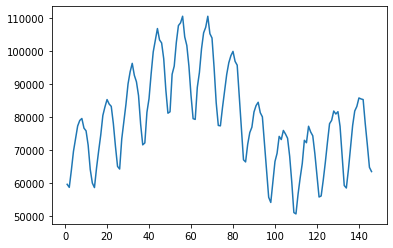

In [24]:
plt.plot(df.Month,df['Total Construction'])

In this data, there are times where contstruction is greater then others. This is due to weather. During the summer months, there are many more total construction projects then there are in the winter. We see the dip in total construction around the time of the recession.

In [25]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df['Total Construction'])
print ('intercept =',intercept, '      slope=',slope,  '         p_value =',p_value)

intercept = 85313.39642158234       slope= -80.58931294766369          p_value = 0.0037274458499943386


p value = model has good fit
intercept = baseline total construction
slope = on average, the demand decreases by 80

In [26]:
def create_regress_col(row, intercept, slope):
    return float(intercept) + float(row['Month']) * slope
    
df['regress'] = df.apply(create_regress_col,args = (intercept,slope),axis = "columns")
df['R1'] = df['Total Construction'] - df['regress']
df.style.format({
    'Total Construction': '{:,.0f}'.format, #formats the output of the dataframe
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1
0,1,Jan-02,"59,516",45273,14243,"85,233","-25,717"
1,2,Feb-02,"58,588",44475,14113,"85,152","-26,564"
2,3,Mar-02,"63,782",49396,14386,"85,072","-21,290"
3,4,Apr-02,"69,504",53283,16221,"84,991","-15,487"
4,5,May-02,"73,384",55009,18375,"84,910","-11,526"
5,6,Jun-02,"77,182",57801,19381,"84,830","-7,648"
6,7,Jul-02,"78,863",58494,20369,"84,749","-5,886"
7,8,Aug-02,"79,460",57953,21507,"84,669","-5,209"
8,9,Sep-02,"76,542",55157,21385,"84,588","-8,046"
9,10,Oct-02,"75,710",56023,19687,"84,508","-8,798"


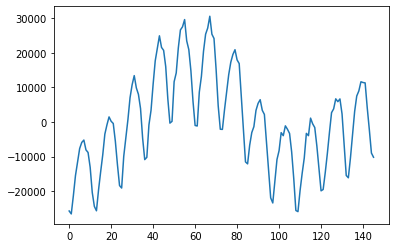

In [27]:
plt.plot(df.index,df.R1) #seasonality of when homes are being built based off the summer months

   Month Month-Year  Total Construction  Private Construction  \
0      1     Jan-02               59516                 45273   
1      2     Feb-02               58588                 44475   
2      3     Mar-02               63782                 49396   
3      4     Apr-02               69504                 53283   
4      5     May-02               73384                 55009   
5      6     Jun-02               77182                 57801   
6      7     Jul-02               78863                 58494   
7      8     Aug-02               79460                 57953   
8      9     Sep-02               76542                 55157   
9     10     Oct-02               75710                 56023   

   Public Construction       regress            R1  lag12  
0                14243  85232.807109 -25716.807109    NaN  
1                14113  85152.217796 -26564.217796    NaN  
2                14386  85071.628483 -21289.628483    NaN  
3                16221  84991.039170 -15487.

Text(0.5, 0, 'Month')

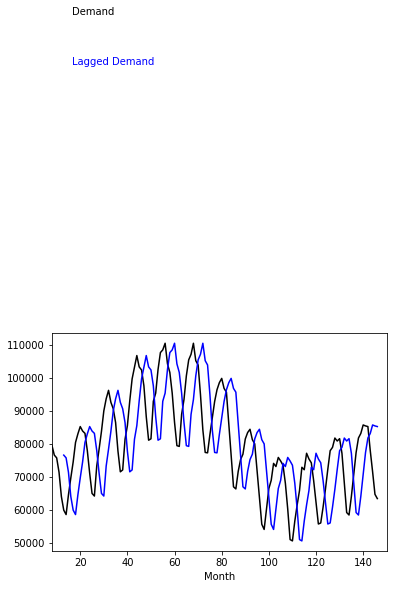

In [28]:
# Create column with lag of 12
lag = 12
df['lag12'] = np.NaN
for i in range(len(df['lag12']))[lag:]:
    df['lag12'].iloc[i] = df['Total Construction'].iloc[i-4]
print(df.head(n=10))

# Compute autocorrelations
for i in range(int(len(df.index)/2)):
    print('autocorrelation, lag =',i,':',df.R1.autocorr(lag = i))
    
fig,ax = plt.subplots()
ax.plot(df.Month,df['Total Construction'],c='k')
ax.plot(df.Month,df.lag12,c='b')
ax.set_xlim([8,150])
ax.text(16.3,210000,'Demand',color='k')
ax.text(16.3,195000,'Lagged Demand',color='b')
ax.set_xlabel('Month')

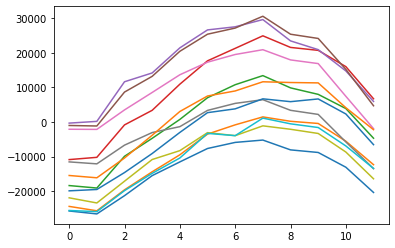

In [29]:
dfMonth = pd.DataFrame()
cycleLen = 12
for i in range(int(len(df['Month'])/cycleLen)):
    newData = pd.DataFrame({i:df['R1'].iloc[i*cycleLen:(i+1)*cycleLen]})
    newData.index = range(0,len(newData))
    dfMonth = pd.concat([dfMonth,newData],axis=1)

fig,ax = plt.subplots()
ax.plot(dfMonth)

Houses trend in the same fashion year over year, it all depends on how the economy is doing to determine the number of bids

               0             1             2             3             4  \
0  -25716.807109 -24388.735353 -18364.663598 -10857.591843   -306.520087   
1  -26564.217796 -25659.146040 -19080.074285 -10203.002530    194.069226   
2  -21289.628483 -19598.556727  -9899.484972   -825.413217  11651.658539   
3  -15487.039170 -14385.967414  -4702.895659   3395.176096  14201.247852   
4  -11526.449857  -9470.378101    759.693654  10949.765409  21452.837165   
5   -7647.860544  -3485.788789   7036.282967  17703.354722  26645.426478   
6   -5886.271231   -811.199476  10798.872280  21309.944035  27542.015791   
7   -5208.681918   1489.389837  13429.461593  24938.533348  29633.605103   
8   -8046.092605    219.979150   9884.050906  21582.122661  23471.194416   
9   -8797.503292   -407.431537   8008.640219  20732.711974  20942.783729   
10 -13064.913979  -5544.842224   3901.229532  16023.301287  14780.373042   
11 -20362.324666 -12329.252911  -4679.181155   6726.890600   5957.962355   

           

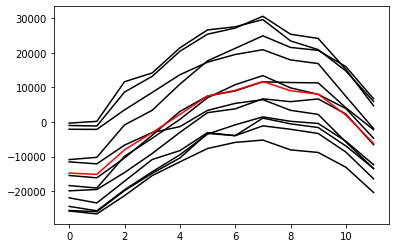

In [30]:
avg = []
for i in range(len(dfMonth.index)):
    avg.append(dfMonth.iloc[i].mean())

dfMonth = pd.concat([dfMonth,pd.DataFrame({'avg':avg})], axis=1)
print(dfMonth)

fig,ax = plt.subplots()
c = 180
for col in dfMonth.columns.values:
    if col == 'avg':
        ax.plot(dfMonth[col], c = 'r')
    else:
        ax.plot(dfMonth[col], c = 'k')

In [31]:
df['S'] = np.NaN
df['R2'] = np.NaN #the second remainder R2, essentially is equal to the epsilon term
df['Composite'] = np.NaN
df['errorPerc'] = np.NaN
S = dfMonth['avg'].values.tolist()
for i in df.index:
    df.loc[i,'S'] = S[i%cycleLen]
    df.loc[i,'R2'] = df.loc[i,'R1'] - df.loc[i,'S']
    df.loc[i,'Composite'] = df.loc[i,'regress'] + df.loc[i,'S']
    df.loc[i,'errorPerc'] = 100*df.loc[i,'R2'] / df.loc[i,'Total Construction']
df.style.format({
    'Product1Demand': '{:,.0f}'.format,
    'regress': '{:,.0f}'.format,
    'R1': '{:,.0f}'.format,
    'S': '{:,.0f}'.format,
    'R2': '{:,.0f}'.format,
    'Composite':'{:,.0f}'.format,
    'errorPerc': '{:.2f}%'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,regress,R1,lag12,S,R2,Composite,errorPerc
0,1,Jan-02,59516,45273,14243,"85,233","-25,717",nan,"-14,754","-10,962","70,478",-18.42%
1,2,Feb-02,58588,44475,14113,"85,152","-26,564",nan,"-15,132","-11,432","70,020",-19.51%
2,3,Mar-02,63782,49396,14386,"85,072","-21,290",nan,"-8,034","-13,256","77,038",-20.78%
3,4,Apr-02,69504,53283,16221,"84,991","-15,487",nan,"-3,068","-12,419","81,923",-17.87%
4,5,May-02,73384,55009,18375,"84,910","-11,526",nan,"2,197","-13,723","87,107",-18.70%
5,6,Jun-02,77182,57801,19381,"84,830","-7,648",nan,"7,521","-15,168","92,350",-19.65%
6,7,Jul-02,78863,58494,20369,"84,749","-5,886",nan,"9,167","-15,054","93,917",-19.09%
7,8,Aug-02,79460,57953,21507,"84,669","-5,209",nan,"11,722","-16,931","96,391",-21.31%
8,9,Sep-02,76542,55157,21385,"84,588","-8,046",nan,"9,050","-17,096","93,638",-22.34%
9,10,Oct-02,75710,56023,19687,"84,508","-8,798",nan,"8,075","-16,872","92,582",-22.29%


The data has a rather high error percentage at first, and then begins to get smaller as more data comes in

Text(0, 0.5, 'Total Construction')

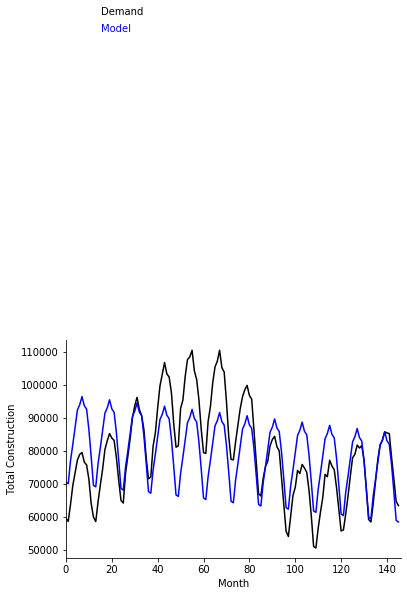

In [32]:
fig, ax = plt.subplots()
ax.plot(df['Total Construction'],c='k')
ax.plot(df['Composite'],c='b')
ax.set_xlim([0,146])
ax.text(15.3,212000,'Demand', color='k')
ax.text(15.3,207000,'Model', color='b')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Month')
ax.set_ylabel('Total Construction')

Time series estimate is not as close as the example

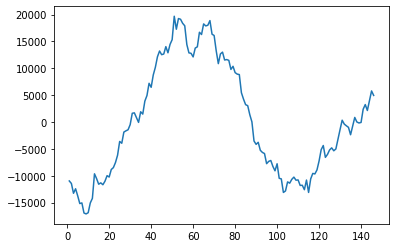

In [33]:
plt.plot(df.Month,df.R2) 

Advanced Time Series Decomposition

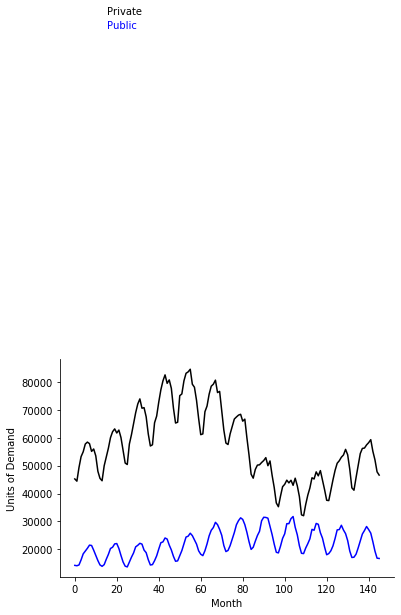

In [34]:
df1 = pd.read_csv('C:\\Users\\thoma\\OneDrive\\Documents\\CIBA\\CTBA\\CTBA\\M3\\ConstructionTimeSeriesDataV2.csv')

fig,ax = plt.subplots()
ax.plot(df1['Private Construction'],label='Private',color='k')
ax.plot(df1['Public Construction'],label='Public',color='b')
ax.set_xlabel('Month')
ax.set_ylabel('Units of Demand')
ax.text(15.3,212000,'Private', color='k')
ax.text(15.3,207000,'Public', color='b')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Consistent trend of when both types of contruction are peaking

C:\Users\thoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\thoma\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


Public Average Squared Error per Month:  14980631.752288744
Private Average Squared Error per Month:  171319951.52171442
            Month Month-Year  Total Construction  Private Construction  \
2003-07-31     37     Jan-05               71474                 57094   
2003-08-31     38     Feb-05               72048                 57531   
2003-09-30     39     Mar-05               81345                 65425   
2003-10-31     40     Apr-05               85485                 67829   
2003-11-30     41     May-05               92959                 72862   
...           ...        ...                 ...                   ...   
2009-04-30    106     Oct-10               73470                 45539   
2009-05-31    107     Nov-10               68019                 42805   
2009-06-30    108     Dec-10               60202                 38928   
2009-07-31    109     Jan-11               50955                 32377   
2009-08-31    110     Feb-11               50544                 

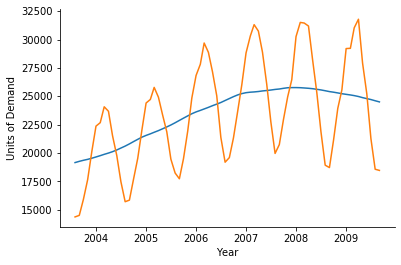

In [35]:
#computing the squared error for the public and private construction over the months

def PubsqErr(row):
    return (row['Public Construction'] - row['PubMovAvg'])**2
    
df1['PubMovAvg'] = np.NaN
df1['PubsqErr'] = np.NaN

# Chaging the DataFrame index to DatetimeIndex data type is required for using one of the functions below
df1.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df1['Public Construction']))
#print(len(data),'\n',data)

window = 36
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is eing computed
for i in range(int(window/2),df1.shape[0]-int(window/2)):
    df1.loc[df1.index[i],'PubMovAvg'] = (0.5*df1.iloc[i - int(window/2)]['Public Construction'] + df.iloc[i - int(window/2)+1:i + int(window/2)]['Public Construction'].sum() + 0.5*df1.iloc[i + int(window/2)]['Public Construction'])/float(window)

#df1['PubsqErr'] = (df1['Public Construction'] - df1['PubMovAvg'])**2
# The squared error can eb computed also with the dfHA.apply() method below
# Using dfHS.apply() in this case is unecessary complexity, but it is a good function to know about
df1['PubsqErr'] = df1.apply(PubsqErr,axis='columns')

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
df1.dropna(how='any',inplace=True)

def PrivatesqErr(row):
    return (row['Private Construction'] - row['PrivateMovAvg'])**2
    
df1['PrivateMovAvg'] = np.NaN
df1['PrivatesqErr'] = np.NaN

# Chaging the DataFrame index to DatetimeIndex data type is required for using one of the functions below
df1.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(df1['Private Construction']))
#print(len(data),'\n',data)

window = 36
window = window - window % 2
# Compute the moving average in the loop below using a window centered on the data point whose average is eing computed
for i in range(int(window/2),df1.shape[0]-int(window/2)):
    df1.loc[df1.index[i],'PrivateMovAvg'] = (0.5*df1.iloc[i - int(window/2)]['Private Construction'] + df.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*df1.iloc[i + int(window/2)]['Private Construction'])/float(window)

#df1['PubsqErr'] = (df1['Public Construction'] - df1['PubMovAvg'])**2
# The squared error can eb computed also with the dfHA.apply() method below
# Using dfHS.apply() in this case is unecessary complexity, but it is a good function to know about
df1['PrivatesqErr'] = df1.apply(PrivatesqErr,axis='columns')

# The moving average cannot be applied to all rows and we need to delete those rows because we cannot use them in the analysis
df1.dropna(how='any',inplace=True)
fig,ax = plt.subplots()
ax.plot(df1['PubMovAvg'],label='Moving Avg.')
ax.plot(df1['Public Construction'],label='Public Construction')
ax.set_xlabel('Year')
ax.set_ylabel('Units of Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Public Average Squared Error per Month: ',sum(df1['PubsqErr'])/len(df1))
print('Private Average Squared Error per Month: ',sum(df1['PrivatesqErr'])/len(df1))
print(df1)





In [165]:
df1

,Month,Month-Year,Total Construction,Private Construction,Public Construction,PubMovAvg,PubsqErr,PrivateMovAvg,PrivatesqErr
2003-07-31,37,Jan-05,71474,57094,14380,19164.805556,2.289436e+07,58574.277778,2.191222e+06
2003-08-31,38,Feb-05,72048,57531,14517,19273.083333,2.262033e+07,58952.125000,2.019596e+06
2003-09-30,39,Mar-05,81345,65425,15920,19365.805556,1.187358e+07,59082.986111,4.022114e+07
2003-10-31,40,Apr-05,85485,67829,17656,19447.902778,3.210916e+06,59419.944444,7.071222e+07
2003-11-30,41,May-05,92959,72862,20097,19547.069444,3.024236e+05,59672.777778,1.739556e+08
...,...,...,...,...,...,...,...,...,...
2009-04-30,106,Oct-10,73470,45539,27931,24883.361111,9.288103e+06,52796.500000,5.267131e+07
2009-05-31,107,Nov-10,68019,42805,25215,24796.388889,1.752353e+05,52171.638889,8.773392e+07
2009-06-30,108,Dec-10,60202,38928,21274,24715.111111,1.184125e+07,51662.138889,1.621583e+08
2009-07-31,109,Jan-11,50955,32377,18578,24608.347222,3.636509e+07,51150.361111,3.524391e+08


In [168]:
#computing the error in the model and the error percentage

df1['R2Public'] = df1['Public Construction'] - df1['PubMovAvg']
df1['R2ErrorPublic'] = abs((df1['R2Public'])/df1['Public Construction'])
df1['R2Private'] = df1['Private Construction'] - df1['PrivateMovAvg']
df1['R2ErrorPrivate'] = abs((df1['R2Private'])/df1['Private Construction'])
df1.style.format({
    'PubMovAvg': '{:.1f}'.format,
    'PubsqErr': '{:,.1f}'.format,
    'PubR1': '{:,.1f}'.format,
    'PubR1Error': '{:,.3f}'.format
})

,Month,Month-Year,Total Construction,Private Construction,Public Construction,PubMovAvg,PubsqErr,PrivateMovAvg,PrivatesqErr,R2Public,R2ErrorPublic,R2Private,R2ErrorPrivate
2003-07-31 00:00:00,37,Jan-05,71474,57094,14380,19164.8,"22,894,364.2",58574.3,2.19122e+06,-4784.81,0.33274,-1480.28,0.025927
2003-08-31 00:00:00,38,Feb-05,72048,57531,14517,19273.1,"22,620,328.7",58952.1,2.0196e+06,-4756.08,0.327622,-1421.12,0.0247019
2003-09-30 00:00:00,39,Mar-05,81345,65425,15920,19365.8,"11,873,575.9",59083,4.02211e+07,-3445.81,0.216445,6342.01,0.0969356
2003-10-31 00:00:00,40,Apr-05,85485,67829,17656,19447.9,"3,210,915.6",59419.9,7.07122e+07,-1791.9,0.10149,8409.06,0.123974
2003-11-30 00:00:00,41,May-05,92959,72862,20097,19547.1,"302,423.6",59672.8,1.73956e+08,549.931,0.0273638,13189.2,0.181016
2003-12-31 00:00:00,42,Jun-05,99632,77258,22375,19659.2,"7,375,448.9",59938.1,2.9998e+08,2715.78,0.121376,17319.9,0.224183
2004-01-31 00:00:00,43,Jul-05,103158,80480,22679,19774.3,"8,437,411.2",60314.6,4.06644e+08,2904.72,0.12808,20165.4,0.250564
2004-02-29 00:00:00,44,Aug-05,106706,82629,24078,19890.1,"17,538,762.3",60936.9,4.70549e+08,4187.93,0.173932,21692.1,0.262525
2004-03-31 00:00:00,45,Sep-05,103269,79584,23685,20002.7,"13,559,169.6",61912.7,3.12277e+08,3682.28,0.155469,17671.3,0.222046
2004-04-30 00:00:00,46,Oct-05,102339,80820,21519,20125.3,"1,942,422.9",62642.3,3.3043e+08,1393.71,0.0647664,18177.7,0.224916


Text(0, 0.5, 'Units of Demand')

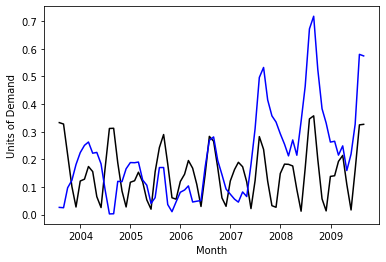

In [170]:
fig,ax = plt.subplots()
ax.plot(df1['R2ErrorPublic'],label='Private',color='k')
ax.plot(df1['R2ErrorPrivate'],label='Public',color='b')
ax.set_xlabel('Month')
ax.set_ylabel('Error PErcentage')


From the graph, it seems that there is greater error percentage in public then private

Average Residual:  120.58522727272724


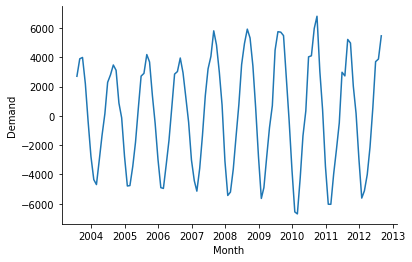

In [142]:
fig,ax = plt.subplots()
ax.plot(df1['PubR1'])
ax.set_xlabel('Month')
ax.set_ylabel('Demand')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
print('Average Residual: ', sum(df1['PubR1'])/len(df1))

In [143]:
maxCorr = 0.0
period = np.NaN
for i in range(1,37):
    corr = df1['PubR1'].autocorr(lag=i)
    print('Correlation, lag ',i,'   ',corr)
    if corr > maxCorr:
        maxCorr = corr
        period = i
print('period = ',period,'     Maximum Correlation = ',maxCorr)

Correlation, lag  1     0.8486375316894602
Correlation, lag  2     0.4846195337567183
Correlation, lag  3     -0.007177248780703143
Correlation, lag  4     -0.49554892375973447
Correlation, lag  5     -0.8288179569669593
Correlation, lag  6     -0.9462777407123573
Correlation, lag  7     -0.8288579638039721
Correlation, lag  8     -0.48571061970010343
Correlation, lag  9     0.004997098591155971
Correlation, lag  10     0.4817646196968951
Correlation, lag  11     0.8389178942275625
Correlation, lag  12     0.9802446550357118
Correlation, lag  13     0.8361843883266434
Correlation, lag  14     0.4848265284305894
Correlation, lag  15     -0.003592213269114516
Correlation, lag  16     -0.48222336701850393
Correlation, lag  17     -0.8171150144686051
Correlation, lag  18     -0.9427534781166457
Correlation, lag  19     -0.8337051906400711
Correlation, lag  20     -0.4961430024835644
Correlation, lag  21     -0.009858447978117565
Correlation, lag  22     0.4684416329134112
Correlation, lag 

Data is extremely correlated from the previous year.

In [144]:
df2 = pd.read_csv('C:\\Users\\thoma\\OneDrive\\Documents\\CIBA\\CTBA\\CTBA\\M3\\ConstructionTimeSeriesDataV2.csv')
